In [12]:
# Cell 1: imports and global style
import json
from pathlib import Path
import itertools
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")


In [13]:
# === Cell 2: load HPD train/test JSON and flatten ===

train_path = Path("en_train_set.json")  # adjust if needed
test_path  = Path("en_test_set.json")   # adjust if needed

def load_hpd_split(path: Path, split_name: str) -> pd.DataFrame:
    """
    Load one HPD split (train or test) and return a flat DataFrame.
    Each row = one session (Session-1, Session-2, ...).
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)  # top-level dict: {"Session-1": {...}, ...}

    records = []
    for sess_id, sess in data.items():
        position = sess.get("position", None)
        speakers = sess.get("speakers", [])  # list of character names

        scene = sess.get("scene", "")
        # In train, scene is often a single string; in test, it can be a list of strings
        if isinstance(scene, list):
            scene_text = " ".join(str(s) for s in scene)
        else:
            scene_text = str(scene)

        dialogue_lines = sess.get("dialogue", [])
        # Ensure a list of strings
        dialogue_lines = [str(x) for x in dialogue_lines]
        # Concatenate dialogue into one string for NLP
        dialogue_text = " ".join(dialogue_lines)

        records.append({
            "split": split_name,
            "session_id": sess_id,
            "position": position,
            "speakers": speakers,
            "scene_text": scene_text,
            "dialogue_lines": dialogue_lines,
            "dialogue_text": dialogue_text,
        })

    return pd.DataFrame(records)

df_train = load_hpd_split(train_path, "train")
df_test  = load_hpd_split(test_path,  "test")

df_hpd = pd.concat([df_train, df_test], ignore_index=True)
print(df_hpd.shape)
df_hpd.head()


(1246, 7)


,split,session_id,position,speakers,scene_text,dialogue_lines,dialogue_text
0,train,Session-1,Book1-chapter2,"[Petunia, Harry]",“Up! Get up! Now!” Harry woke with a start. Hi...,[Petunia: Up! Get up! Now! Up! Up! Are you up ...,Petunia: Up! Get up! Now! Up! Up! Are you up y...
1,train,Session-2,Book1-chapter2,"[Petunia, Vernon, Harry]","“Bad news, Vernon,” she said. “Mrs. Figg’s bro...","[Petunia: Bad news, Vernon, Mrs. Figg’s broken...","Petunia: Bad news, Vernon, Mrs. Figg’s broken ..."
2,train,Session-3,Book1-chapter2,"[Vernon, Harry]","“. . . roaring along like maniacs, the young h...","[Vernon: . . . roaring along like maniacs, the...","Vernon: . . . roaring along like maniacs, the ..."
3,train,Session-4,Book1-chapter3,"[Harry, Petunia]",“What’s this?” he asked Aunt Petunia. Her lips...,"[Harry: What’s this?, Petunia: Your new school...",Harry: What’s this? Petunia: Your new school u...
4,train,Session-5,Book1-chapter3,"[Vernon, Dudley, Harry, Petunia]","“Get the mail, Dudley,” said Uncle Vernon from...","[Vernon: Get the mail, Dudley, Dudley: Make Ha...","Vernon: Get the mail, Dudley Dudley: Make Harr..."


In [14]:
# === Cell 3: sentiment analysis on dialogue_text ===

# Install once per runtime (comment out if already installed)
!pip install -q transformers accelerate torch

from transformers import pipeline

# Simple English sentiment model
sent_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def sentiment_score(text: str) -> float:
    """
    Map text to a scalar sentiment in [-1, 1].
    Positive label -> +score, negative label -> -score.
    """
    if not isinstance(text, str) or not text.strip():
        return 0.0
    # Truncate long dialogues for speed / model limits
    text_trunc = text[:512]
    result = sent_pipe(text_trunc)[0]
    label = result["label"].upper()
    score = float(result["score"])
    if label == "NEGATIVE":
        return -score
    else:
        return score

# This can be slow on the full set; if needed, start with df_hpd.head(200)
df_hpd["sentiment"] = df_hpd["dialogue_text"].apply(sentiment_score)
df_hpd[["split", "session_id", "position", "speakers", "sentiment"]].head()


Device set to use cpu


,split,session_id,position,speakers,sentiment
0,train,Session-1,Book1-chapter2,"[Petunia, Harry]",-0.997996
1,train,Session-2,Book1-chapter2,"[Petunia, Vernon, Harry]",-0.998435
2,train,Session-3,Book1-chapter2,"[Vernon, Harry]",-0.909861
3,train,Session-4,Book1-chapter3,"[Harry, Petunia]",-0.982691
4,train,Session-5,Book1-chapter3,"[Vernon, Dudley, Harry, Petunia]",0.984364


In [15]:
# === Cell 4: co-occurrence + sentiment network ===

G_hp_text = nx.Graph()

for _, row in df_hpd.iterrows():
    speakers = row["speakers"]
    s_score = row["sentiment"]

    # Normalize speaker names
    speakers = [str(s).strip() for s in speakers if pd.notna(s)]
    speakers = [s for s in speakers if s != ""]
    speakers_unique = sorted(set(speakers))

    # Add edges for all unordered pairs of speakers
    for u, v in itertools.combinations(speakers_unique, 2):
        if G_hp_text.has_edge(u, v):
            # Update weight and running sentiment statistics
            G_hp_text[u][v]["weight"] += 1
            G_hp_text[u][v]["sent_sum"] += s_score
            G_hp_text[u][v]["sent_count"] += 1
        else:
            G_hp_text.add_edge(
                u, v,
                weight=1,
                sent_sum=s_score,
                sent_count=1,
            )

# Add mean sentiment on each edge
for u, v, data in G_hp_text.edges(data=True):
    n = data.get("sent_count", 1)
    data["sent_mean"] = data.get("sent_sum", 0.0) / n

print("HPD text network:",
      G_hp_text.number_of_nodes(), "nodes,",
      G_hp_text.number_of_edges(), "edges")


HPD text network: 364 nodes, 2605 edges


In [16]:
# === Cell 5: node-level text features from dialogue ===

def tokenize_simple(text: str):
    """Very simple word tokenizer for English."""
    return re.findall(r"[A-Za-z']+", text.lower())

char_texts = defaultdict(list)
char_sent  = defaultdict(list)

for _, row in df_hpd.iterrows():
    speakers = [str(s).strip() for s in row["speakers"] if pd.notna(s)]
    speakers = [s for s in speakers if s != ""]
    text = row["dialogue_text"]
    s_score = row["sentiment"]
    for c in set(speakers):
        char_texts[c].append(text)
        char_sent[c].append(s_score)

node_features = []

for c, texts in char_texts.items():
    joined = " ".join(texts)
    tokens = tokenize_simple(joined)
    n_tokens = len(tokens)
    vocab = set(tokens)
    vocab_size = len(vocab)
    avg_sent = float(np.mean(char_sent[c])) if char_sent[c] else 0.0

    node_features.append({
        "character": c,
        "n_sessions": len(texts),
        "n_tokens": n_tokens,
        "vocab_size": vocab_size,
        "type_token_ratio": vocab_size / n_tokens if n_tokens > 0 else 0.0,
        "mean_dialogue_sentiment": avg_sent,
    })

df_char = pd.DataFrame(node_features)
df_char.sort_values("n_sessions", ascending=False).head(10)


,character,n_sessions,n_tokens,vocab_size,type_token_ratio,mean_dialogue_sentiment
0,Harry,1215,307238,10522,0.034247,-0.385120
21,Ron,640,168938,7750,0.045875,-0.458089
26,Hermione,524,157830,7489,0.047450,-0.494180
4,Hagrid,116,31341,3102,0.098976,-0.419586
18,Fred,98,35496,3485,0.098180,-0.399805
34,Dumbledore,96,47180,4375,0.092730,-0.128758
62,Mrs. Weasley,81,21059,2524,0.119854,-0.198977
17,Ginny,77,25370,2741,0.108041,-0.363630
23,George,72,27086,2956,0.109134,-0.465636
31,McGonagall,70,22749,2821,0.124005,-0.162391


In [17]:
# === Cell 6: attach node features to G_hp_text ===

for _, row in df_char.iterrows():
    c = row["character"]
    if c not in G_hp_text:
        G_hp_text.add_node(c)
    G_hp_text.nodes[c]["n_sessions"] = row["n_sessions"]
    G_hp_text.nodes[c]["n_tokens"] = row["n_tokens"]
    G_hp_text.nodes[c]["vocab_size"] = row["vocab_size"]
    G_hp_text.nodes[c]["type_token_ratio"] = row["type_token_ratio"]
    G_hp_text.nodes[c]["mean_dialogue_sentiment"] = row["mean_dialogue_sentiment"]

# Quick check for one character
some_node = list(G_hp_text.nodes())[0]
G_hp_text.nodes[some_node]


{'n_sessions': 1215,
 'n_tokens': 307238,
 'vocab_size': 10522,
 'type_token_ratio': 0.03424706579264284,
 'mean_dialogue_sentiment': -0.38511989347238107}

In [18]:
# Rebuild df_struct (centrality + structural-hole measures) from G_hp_text

# Weighted degree (by co-occurrence count)
deg_w = dict(G_hp_text.degree(weight="weight"))

# Weighted betweenness (higher if a node lies on many strong co-occurrence paths)
betw_w = nx.betweenness_centrality(G_hp_text, weight="weight", normalized=True)

# k-core on the undirected graph
core_num = nx.core_number(G_hp_text)

# Precompute neighbor sets and unweighted degree for bridging coefficient
neighbors = {v: set(G_hp_text.neighbors(v)) for v in G_hp_text.nodes()}
deg_unw = dict(G_hp_text.degree())

bridging_coeff = {}
bridging_centrality = {}

for v in G_hp_text.nodes():
    k_v = deg_unw.get(v, 0)
    if k_v == 0:
        bridging_coeff[v] = 0.0
        bridging_centrality[v] = 0.0
        continue
    neigh = neighbors[v]
    if not neigh:
        bridging_coeff[v] = 0.0
        bridging_centrality[v] = 0.0
        continue
    denom = sum(1.0 / deg_unw.get(u, 1) for u in neigh)
    bc = (1.0 / k_v) / denom if denom > 0 else 0.0
    bridging_coeff[v] = bc
    bridging_centrality[v] = bc * betw_w.get(v, 0.0)

df_struct = []

for v in G_hp_text.nodes():
    df_struct.append({
        "character": v,
        "degree_weighted": deg_w.get(v, 0),
        "betweenness_weighted": betw_w.get(v, 0.0),
        "kcore": core_num.get(v, 0),
        "bridging_coeff": bridging_coeff.get(v, 0.0),
        "bridging_centrality": bridging_centrality.get(v, 0.0),
        "n_sessions": G_hp_text.nodes[v].get("n_sessions", 0),
        "type_token_ratio": G_hp_text.nodes[v].get("type_token_ratio", 0.0),
        "mean_dialogue_sentiment": G_hp_text.nodes[v].get("mean_dialogue_sentiment", 0.0),
    })

df_struct = pd.DataFrame(df_struct)
df_struct.sort_values("degree_weighted", ascending=False).head(15)


,character,degree_weighted,betweenness_weighted,kcore,bridging_coeff,bridging_centrality,n_sessions,type_token_ratio,mean_dialogue_sentiment
0,Harry,3395,0.405042,18,0.000041,0.000017,1215,0.034247,-0.385120
24,Ron,2089,0.117498,18,0.000138,0.000016,640,0.045875,-0.458089
26,Hermione,1813,0.105872,18,0.000149,0.000016,524,0.047450,-0.494180
17,Fred,557,0.017445,18,0.001818,0.000032,98,0.098180,-0.399805
21,George,411,0.013174,18,0.002906,0.000038,72,0.109134,-0.465636
4,Hagrid,381,0.033780,18,0.001382,0.000047,116,0.098976,-0.419586
18,Ginny,371,0.017665,18,0.003066,0.000054,77,0.108041,-0.363630
62,Mrs. Weasley,340,0.002362,18,0.010014,0.000024,81,0.119854,-0.198977
31,McGonagall,306,0.019168,18,0.001790,0.000034,70,0.124005,-0.162391
22,Neville,303,0.024485,18,0.002187,0.000054,58,0.125768,-0.505241


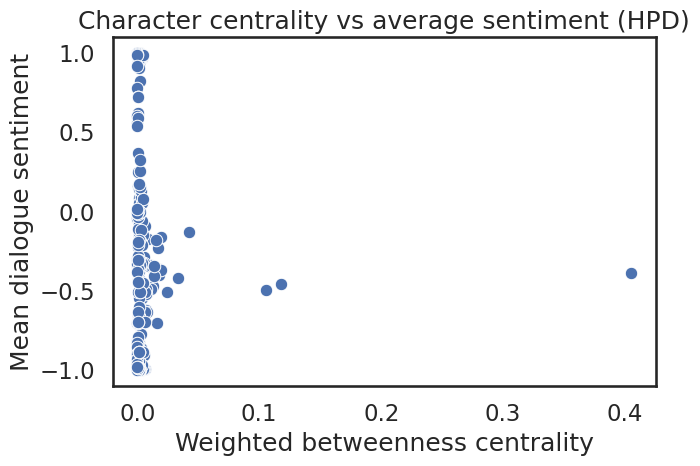

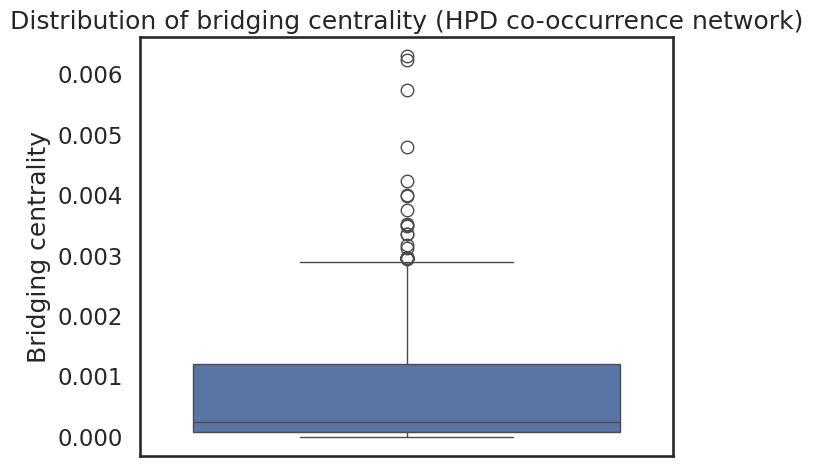

In [19]:
# === Cell 8: example plots ===

# 8a. Character centrality vs average dialogue sentiment
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_struct,
    x="betweenness_weighted",
    y="mean_dialogue_sentiment"
)
plt.xlabel("Weighted betweenness centrality")
plt.ylabel("Mean dialogue sentiment")
plt.title("Character centrality vs average sentiment (HPD)")
plt.tight_layout()
plt.show()

# 8b. Bridging centrality distribution (characters that often connect groups)
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df_struct,
    y="bridging_centrality"
)
plt.ylabel("Bridging centrality")
plt.title("Distribution of bridging centrality (HPD co-occurrence network)")
plt.tight_layout()
plt.show()


In [20]:
# === Cell 9: character-level sentiment and centrality summaries ===

# Top central characters by weighted degree
top_deg = df_struct.sort_values("degree_weighted", ascending=False).head(15)
print("Top 15 characters by weighted degree (co-occurrence strength):")
display(top_deg[["character", "degree_weighted", "betweenness_weighted",
                 "kcore", "bridging_centrality",
                 "n_sessions", "type_token_ratio", "mean_dialogue_sentiment"]])

# Most positive / negative characters by average dialogue sentiment
min_sessions = 5  # avoid noise from characters appearing only once
sub = df_struct[df_struct["n_sessions"] >= min_sessions].copy()

top_positive = sub.sort_values("mean_dialogue_sentiment", ascending=False).head(10)
top_negative = sub.sort_values("mean_dialogue_sentiment", ascending=True).head(10)

print(f"\nTop 10 most positive characters (n_sessions >= {min_sessions}):")
display(top_positive[["character", "n_sessions", "mean_dialogue_sentiment",
                      "degree_weighted", "betweenness_weighted"]])

print(f"\nTop 10 most negative characters (n_sessions >= {min_sessions}):")
display(top_negative[["character", "n_sessions", "mean_dialogue_sentiment",
                      "degree_weighted", "betweenness_weighted"]])


Top 15 characters by weighted degree (co-occurrence strength):


,character,degree_weighted,betweenness_weighted,kcore,bridging_centrality,n_sessions,type_token_ratio,mean_dialogue_sentiment
0,Harry,3395,0.405042,18,0.000017,1215,0.034247,-0.385120
24,Ron,2089,0.117498,18,0.000016,640,0.045875,-0.458089
26,Hermione,1813,0.105872,18,0.000016,524,0.047450,-0.494180
17,Fred,557,0.017445,18,0.000032,98,0.098180,-0.399805
21,George,411,0.013174,18,0.000038,72,0.109134,-0.465636
4,Hagrid,381,0.033780,18,0.000047,116,0.098976,-0.419586
18,Ginny,371,0.017665,18,0.000054,77,0.108041,-0.363630
62,Mrs. Weasley,340,0.002362,18,0.000024,81,0.119854,-0.198977
31,McGonagall,306,0.019168,18,0.000034,70,0.124005,-0.162391
22,Neville,303,0.024485,18,0.000054,58,0.125768,-0.505241



Top 10 most positive characters (n_sessions >= 5):


,character,n_sessions,mean_dialogue_sentiment,degree_weighted,betweenness_weighted
286,Sprout,5,0.591910,23,0.000249
70,Colin,8,0.258444,31,0.002500
270,Slughorn,19,0.173084,65,0.001600
15,Ollivander,5,0.160040,18,0.000361
155,Fleur,22,0.154235,125,0.002608
118,Cho Chang,17,0.131350,94,0.002858
45,Wood,22,0.093053,87,0.003419
10,Tom,9,0.083956,19,0.001206
131,Bagman,15,0.082046,74,0.005111
43,Fat lady,15,0.056306,36,0.001359



Top 10 most negative characters (n_sessions >= 5):


,character,n_sessions,mean_dialogue_sentiment,degree_weighted,betweenness_weighted
191,Mrs. Black,5,-0.998797,22,0.000651
90,wizard,8,-0.991225,46,0.006107
262,Death Eater,8,-0.990925,49,0.004966
168,Grubbly-Plank,6,-0.989103,20,0.000542
132,Crouch,6,-0.977496,36,0.001853
160,Pansy,6,-0.722686,32,0.002617
59,Madam Pomfrey,15,-0.720199,58,0.002658
14,stranger,21,-0.698969,104,0.015969
255,Bellatrix,7,-0.694529,46,0.006492
332,Xenophilius,7,-0.692892,22,0.000228


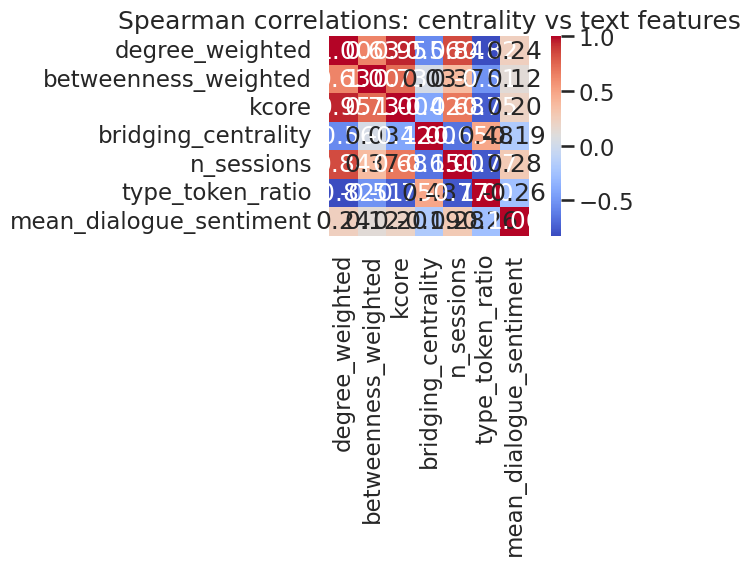

In [21]:
# === Cell 10: correlation between centrality and text-based features ===

corr_cols = [
    "degree_weighted",
    "betweenness_weighted",
    "kcore",
    "bridging_centrality",
    "n_sessions",
    "type_token_ratio",
    "mean_dialogue_sentiment",
]

corr_mat = df_struct[corr_cols].corr(method="spearman")
corr_mat
# === Cell 10b: visualize correlation matrix ===

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    square=True,
    cmap="coolwarm",
)
plt.title("Spearman correlations: centrality vs text features")
plt.tight_layout()
plt.show()


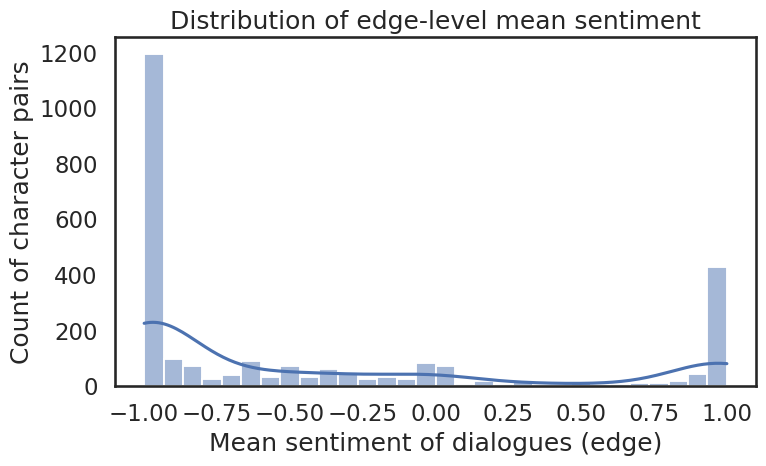

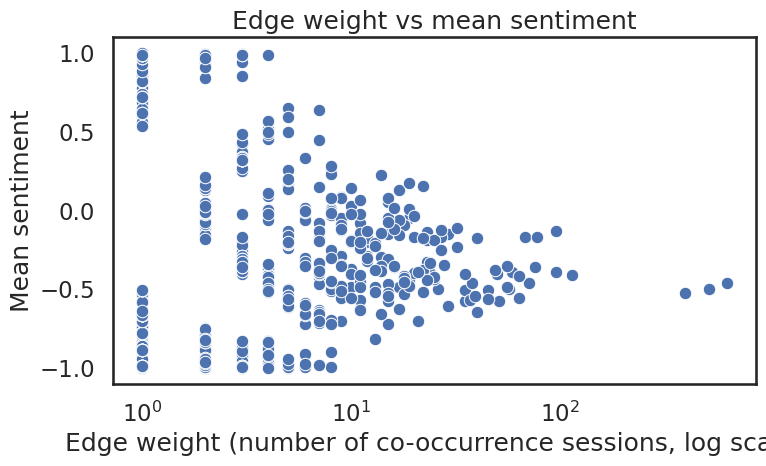

Most positive pairs (weight >= 3):


,u,v,weight,sent_mean
297,Harry,Doge,3,0.995564
158,Harry,Rita Skeeter,4,0.987141
1503,McGonagall,Wood,3,0.985198
2545,Slughorn,Sprout,3,0.984576
271,Harry,Romilda,3,0.944921
1242,Hermione,Lockhart,3,0.851264
663,Fred,McGonagall,5,0.648613
1749,Weasley,Sirius,7,0.639355
1825,Dean,Parvati,5,0.592813
285,Harry,Sprout,5,0.591910



Most negative pairs (weight >= 3):


,u,v,weight,sent_mean
1089,Ron,Mrs. Black,3,-0.998973
190,Harry,Mrs. Black,5,-0.998797
1325,Hermione,Mrs. Black,4,-0.998657
356,Harry,Filth,3,-0.997678
1277,Hermione,Crouch,3,-0.997538
1733,Weasley,Crouch,3,-0.997538
1041,Ron,Crouch,3,-0.997538
1165,Ron,Voldemort,3,-0.997088
1403,Hermione,Voldemort,3,-0.995571
1673,Snape,Madam Pomfrey,3,-0.995434


In [22]:
# === Cell 11: build edge-level DataFrame from G_hp_text ===

edge_rows = []
for u, v, data in G_hp_text.edges(data=True):
    edge_rows.append({
        "u": u,
        "v": v,
        "weight": data.get("weight", 1),
        "sent_mean": data.get("sent_mean", 0.0),
    })

df_edges = pd.DataFrame(edge_rows)
df_edges.head()
# === Cell 11b: distribution of edge sentiment ===

plt.figure(figsize=(8, 5))
sns.histplot(df_edges["sent_mean"], bins=30, kde=True)
plt.xlabel("Mean sentiment of dialogues (edge)")
plt.ylabel("Count of character pairs")
plt.title("Distribution of edge-level mean sentiment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_edges,
    x="weight",
    y="sent_mean",
)
plt.xscale("log")
plt.xlabel("Edge weight (number of co-occurrence sessions, log scale)")
plt.ylabel("Mean sentiment")
plt.title("Edge weight vs mean sentiment")
plt.tight_layout()
plt.show()
# === Cell 11c: top positive and negative pairs (strong ties) ===

min_weight = 3  # consider only pairs that co-occur in at least 3 sessions
sub_edges = df_edges[df_edges["weight"] >= min_weight].copy()

top_pos_edges = sub_edges.sort_values("sent_mean", ascending=False).head(15)
top_neg_edges = sub_edges.sort_values("sent_mean", ascending=True).head(15)

print(f"Most positive pairs (weight >= {min_weight}):")
display(top_pos_edges)

print(f"\nMost negative pairs (weight >= {min_weight}):")
display(top_neg_edges)


In [23]:
# === Cell 12: character-level tf–idf keywords ===

from sklearn.feature_extraction.text import TfidfVectorizer

# Rebuild char_texts from df_hpd to be safe
char_texts = defaultdict(list)
for _, row in df_hpd.iterrows():
    speakers = [str(s).strip() for s in row["speakers"] if pd.notna(s)]
    speakers = [s for s in speakers if s != ""]
    text = row["dialogue_text"]
    for c in set(speakers):
        char_texts[c].append(text)

char_list = []
corpus = []

for c, texts in char_texts.items():
    char_list.append(c)
    corpus.append(" ".join(texts))

vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"[A-Za-z']+",
    min_df=3,   # ignore rare words
)
X = vectorizer.fit_transform(corpus)
vocab = np.array(vectorizer.get_feature_names_out())

# Helper: get top k tf–idf terms for a character index i
def top_terms_for_char(idx, k=10):
    row = X[idx]
    if row.nnz == 0:
        return []
    # get top k indices
    data = row.toarray().ravel()
    top_idx = np.argsort(data)[::-1][:k]
    return list(zip(vocab[top_idx], data[top_idx]))
# === Cell 12b: show keywords for top central characters ===

# Choose some target characters: top by weighted degree
top_chars = df_struct.sort_values("degree_weighted", ascending=False)["character"].head(5).tolist()

print("Top tf–idf keywords for top-degree characters:\n")
for c in top_chars:
    if c not in char_list:
        continue
    idx = char_list.index(c)
    terms = top_terms_for_char(idx, k=12)
    print(f"Character: {c}")
    for w, score in terms:
        print(f"  {w:15s} {score:.4f}")
    print()


Top tf–idf keywords for top-degree characters:

Character: Harry
  you             0.3368
  i               0.3056
  the             0.3009
  to              0.2686
  harry           0.2278
  s               0.2022
  it              0.1990
  and             0.1689
  a               0.1601
  of              0.1563
  he              0.1560
  t               0.1536

Character: Ron
  you             0.3255
  the             0.2844
  i               0.2832
  to              0.2605
  s               0.2189
  it              0.2075
  harry           0.2056
  ron             0.2055
  hermione        0.1775
  t               0.1680
  and             0.1668
  a               0.1592

Character: Hermione
  you             0.3136
  the             0.2928
  i               0.2795
  to              0.2618
  hermione        0.2243
  s               0.2166
  it              0.2098
  harry           0.2035
  t               0.1667
  ron             0.1653
  and             0.1647
  he              0.155

In [24]:
# === Cell 13: communities in the text-derived network and their keywords ===

import networkx.algorithms.community as nx_comm

# Community detection: greedy modularity on undirected graph
communities = list(nx_comm.greedy_modularity_communities(G_hp_text))
print(f"Detected {len(communities)} communities.")

# Build DataFrame with community id for each node
node_to_comm = {}
for cid, comm in enumerate(communities):
    for v in comm:
        node_to_comm[v] = cid

df_struct["community"] = df_struct["character"].map(node_to_comm)

# Community sizes
comm_sizes = df_struct["community"].value_counts().sort_index()
comm_sizes
# === Cell 13b: tf–idf keywords per large community ===

# Aggregate text for each community
comm_texts = defaultdict(list)

for _, row in df_hpd.iterrows():
    speakers = [str(s).strip() for s in row["speakers"] if pd.notna(s)]
    speakers = [s for s in speakers if s != ""]
    text = row["dialogue_text"]
    # Assign this session to all communities represented by its speakers
    for c in set(speakers):
        cid = node_to_comm.get(c, None)
        if cid is not None:
            comm_texts[cid].append(text)

# Build corpus per community
comm_ids = sorted(comm_texts.keys())
comm_corpus = [" ".join(comm_texts[cid]) for cid in comm_ids]

vectorizer_comm = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"[A-Za-z']+",
    min_df=5,   # slightly stricter for community-level
)
Xc = vectorizer_comm.fit_transform(comm_corpus)
vocab_c = np.array(vectorizer_comm.get_feature_names_out())

def top_terms_for_comm(idx, k=15):
    row = Xc[idx]
    if row.nnz == 0:
        return []
    data = row.toarray().ravel()
    top_idx = np.argsort(data)[::-1][:k]
    return list(zip(vocab_c[top_idx], data[top_idx]))

# Show keywords for communities with at least 5 members
min_size = 5
print("Community-level keywords (only communities with size >= 5):\n")
for cid in comm_ids:
    size = comm_sizes.get(cid, 0)
    if size < min_size:
        continue
    terms = top_terms_for_comm(comm_ids.index(cid), k=15)
    print(f"Community {cid} (size={size}):")
    print("  Members (sample):",
          ", ".join(df_struct[df_struct["community"] == cid]["character"].head(5).tolist()))
    for w, score in terms:
        print(f"  {w:15s} {score:.4f}")
    print()


Detected 8 communities.
Community-level keywords (only communities with size >= 5):

Community 0 (size=101):
  Members (sample): Griphook, Ollivander, Ron, Hermione, Trains
  the             0.3408
  you             0.3384
  to              0.2932
  i               0.2917
  s               0.2440
  harry           0.2195
  it              0.2134
  t               0.1843
  and             0.1841
  hermione        0.1802
  ron             0.1693
  of              0.1578
  a               0.1550
  he              0.1499
  that            0.1357

Community 1 (size=93):
  Members (sample): Harry, Petunia, Vernon, Dudley, Tom
  the             0.3645
  you             0.3579
  i               0.3180
  to              0.3094
  harry           0.2237
  s               0.2077
  of              0.1883
  and             0.1880
  it              0.1869
  t               0.1608
  that            0.1602
  a               0.1578
  he              0.1523
  we              0.1037
  in              0.09